In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction import DictVectorizer
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.externals import joblib
from sklearn import svm
from sklearn import decomposition
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from time import time
import json
import os
# The usual preamble
%matplotlib inline
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, andigger
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)

C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
path = os.path.dirname(os.getcwd())
month = '06'
isWeekday = True

trainFileName = 'trainData/%s_%s_train.csv'%(month,'weekday' if isWeekday else 'weekend')
if not os.path.exists(trainFileName):  

    # processing taxi data
    taxi = pd.read_csv(path+'/PreProcessTaxiData/TaxiDataProcessed/cleanData_yellow_tripdata_2016-%s.csv'%month)
    taxi = taxi[['tpep_pickup_datetime','trip_distance','duration','total_amount']]
    taxi.index = taxi['tpep_pickup_datetime'].str.slice(8,13)
    taxi.index.names=['Time']
    taxi['day_of_week'] = pd.to_datetime(taxi['tpep_pickup_datetime']).dt.dayofweek
    if isWeekday:
        # remove weekend
        taxi = taxi[taxi['day_of_week'] <= 4]
    else:
        # remove weekday
        taxi = taxi[taxi['day_of_week'] > 4]
    del taxi['day_of_week']
    del taxi['tpep_pickup_datetime']

    # processing weather data
    weather = pd.read_csv(path+'/PreProcessWeatherData/weather_processed_again/weather_2016_%s.csv'%month,index_col='Time')
    weather.drop(['Humidity','Barometer'],axis=1,inplace=True)
    weather.index = weather.index.str.slice(0,5)

    # concat two dataframes
    result = taxi.join(weather)
    result.index = result.index.str.slice(3,5)
    del taxi
    del weather

    result.to_csv(trainFileName, mode='w')
else:
    result = pd.read_csv(trainFileName, index_col='Time')

In [4]:
result.head()

,trip_distance,duration,total_amount,Temp,Weather,Wind,Visibility
Time,,,,,,,
00,0.80,287.0,8.16,73,clear,0,8
00,12.10,1514.0,43.80,73,clear,0,8
00,1.26,349.0,9.36,73,clear,0,8
00,3.31,1026.0,15.30,73,clear,0,8
00,1.41,482.0,10.05,73,clear,0,8


In [5]:
length = len(result)
df = result.iloc[random.sample(range(0, length), int(length*0.001))]

In [8]:
vecX = [df[['Weather']].iloc[index].to_dict() for index in range(len(df))]
if os.path.exists('models/%s_vec.pkl'%month):
    vec = joblib.load('models/%s_vec.pkl'%month)
    dummyX = vec.transform(vecX).toarray()
else:
    vec = DictVectorizer()    
    dummyX = vec.fit_transform(vecX).toarray()
    joblib.dump(vec, 'models/%s_vec.pkl'%month)
print(vec.get_feature_names())


['Weather=clear', 'Weather=cloud', 'Weather=fog', 'Weather=heavy rain', 'Weather=light rain']


In [9]:
vecX = pd.DataFrame(dummyX,columns=vec.get_feature_names())
vecX.index = df.index
df = pd.concat([df,vecX],axis=1)

In [10]:
df.head()

,trip_distance,duration,total_amount,Temp,Weather,Wind,Visibility,Weather=clear,Weather=cloud,Weather=fog,Weather=heavy rain,Weather=light rain
Time,,,,,,,,,,,,
20,2.10,771.0,14.15,65,cloud,5,8,0.0,1.0,0.0,0.0,0.0
08,1.70,871.0,14.15,75,clear,3,8,1.0,0.0,0.0,0.0,0.0
18,1.20,651.0,11.80,70,cloud,0,6,0.0,1.0,0.0,0.0,0.0
00,1.32,246.0,8.76,67,cloud,0,7,0.0,1.0,0.0,0.0,0.0
21,0.56,196.0,5.80,78,clear,0,9,1.0,0.0,0.0,0.0,0.0


In [11]:
del df['Weather']

In [12]:
y = np.array(df['total_amount'])
del df['total_amount']
X = np.array(df)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
def gridSearchCV(clf, param_grid,score=make_scorer(r2_score)):
    # scoring = {'evc': make_scorer(explained_variance_score), 'r2_score': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=score)
    start = time()
    grid_search.fit(X_train, y_train)
    bestScore = round(grid_search.best_score_, 4)
    parameters = grid_search.best_params_
    print("Best Score: " + str(bestScore) + "\nParameters: " + str(parameters))
    return bestScore, parameters, grid_search.best_estimator_

# SVR RBF kernel
svr_rbf = svm.SVR(kernel='rbf')
param_grid = {"C": [1, 10, 100, 1000], "gamma": np.logspace(-2, 2, 5)}
svr_rbf_score, parameters, svr_rbf = gridSearchCV(svr_rbf, param_grid)

# Gradient Boosting regression
gbr = GradientBoostingRegressor()
param_grid = {'n_estimators': [500, 700, 900], 'max_depth': [1, 2], 'min_samples_split': [2], 
          'learning_rate': [0.01, 0.1], 'loss': ['lad']}
gbr_score, parameters, gbr = gridSearchCV(gbr, param_grid)

# Kernel Ridge Regression
krr = KernelRidge(kernel='rbf')
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)}
krr_score, parameters, krr = gridSearchCV(krr, param_grid)

# DecisionTreeRegressor
dtr = DecisionTreeRegressor()
param_grid = {'max_depth': [2, 4, 6, 8]}
dtr_score, parameters, dtr = gridSearchCV(dtr, param_grid)

# KNeighborsRegressor
knr = KNeighborsRegressor()
param_grid = {'n_neighbors': [2, 4, 6, 8]}
knr_score, parameters, knr = gridSearchCV(knr, param_grid)

# RandomForestRegressor
rfr = RandomForestRegressor()
param_grid = {'max_depth': [2, 4, 6, 8], 'n_estimators': [20, 50, 150, 500]}
rfr_score, parameters, rfr = gridSearchCV(rfr, param_grid)

# AdaBoostRegressor
adr = AdaBoostRegressor()
param_grid = {'n_estimators': [20, 50, 150, 500]}
adr_score, parameters, adr = gridSearchCV(adr, param_grid)


Best Score: 0.762
Parameters: {'C': 100, 'gamma': 0.01}
Best Score: 0.9524
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.01, 'n_estimators': 900, 'max_depth': 2}
Best Score: 0.4185
Parameters: {'alpha': 0.01, 'gamma': 0.01}
Best Score: 0.9433
Parameters: {'max_depth': 6}
Best Score: 0.8165
Parameters: {'n_neighbors': 4}
Best Score: 0.955
Parameters: {'n_estimators': 500, 'max_depth': 8}
Best Score: 0.9262
Parameters: {'n_estimators': 20}


bestModel: RandomForestRegressor


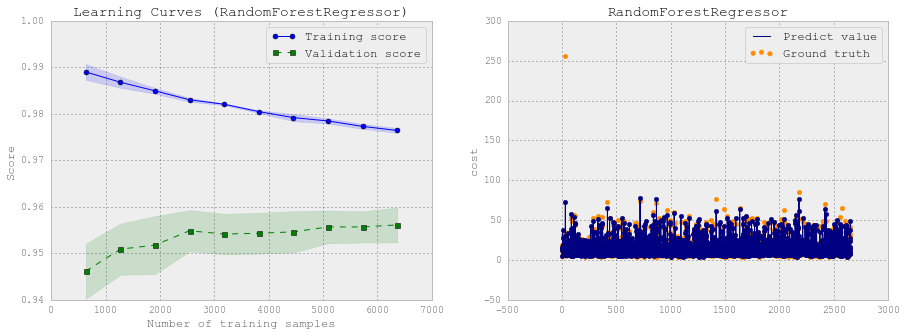

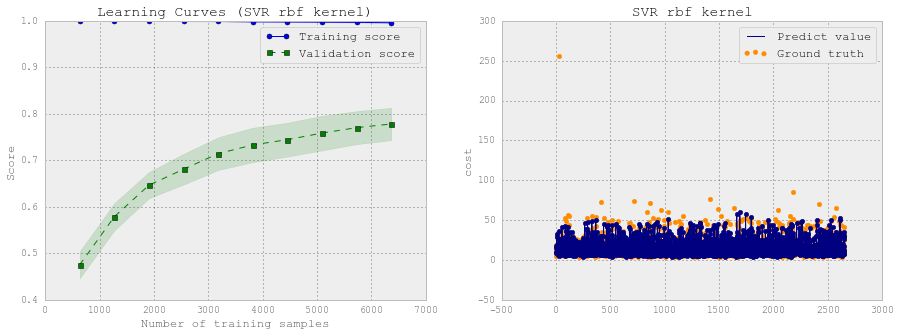

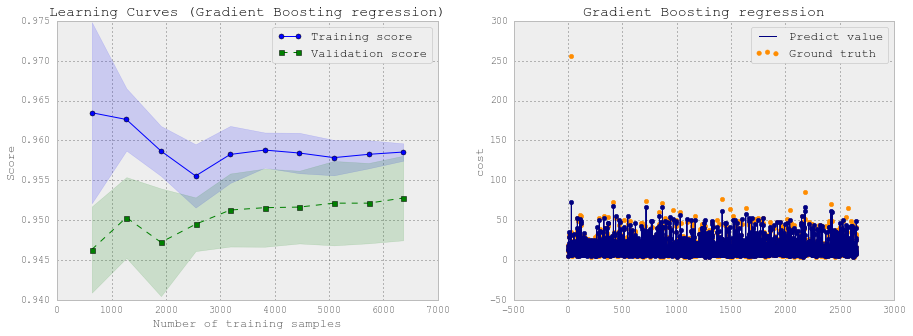

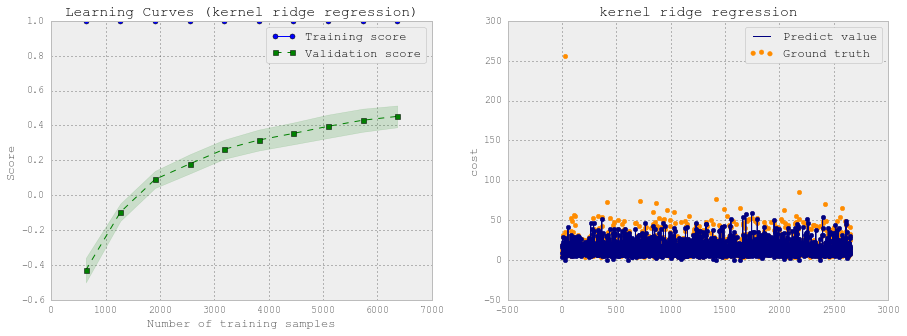

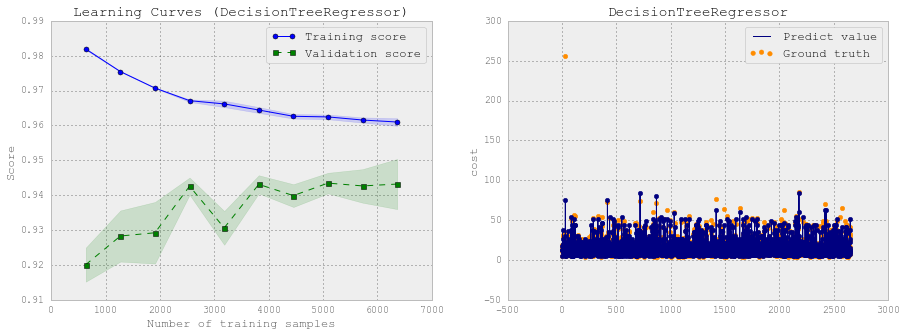

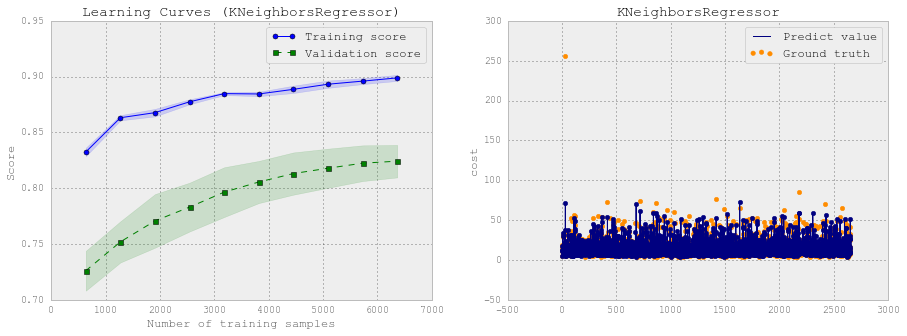

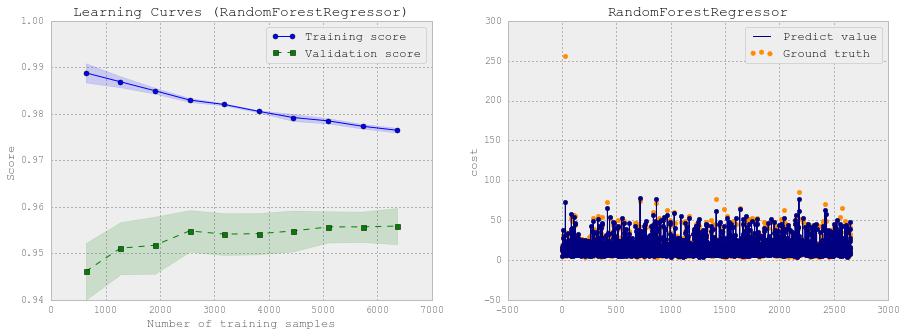

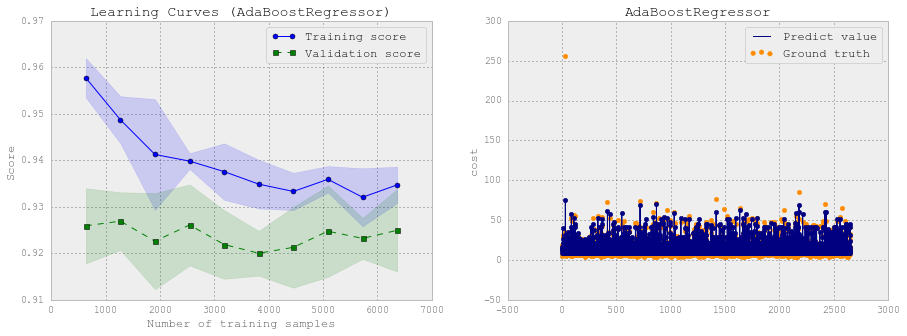

In [16]:
# #############################################################################
# select model with minimized mse and save model
models = [(svr_rbf,'SVR rbf kernel'),\
          (gbr,'Gradient Boosting regression'),(krr,'kernel ridge regression'),\
         (dtr,'DecisionTreeRegressor'),(knr,'KNeighborsRegressor'), (rfr,'RandomForestRegressor'),\
         (adr,'AdaBoostRegressor')]
scores = [svr_rbf_score, gbr_score, krr_score, dtr_score,\
          knr_score, rfr_score, adr_score]

index = max(enumerate(scores),key=lambda x: x[1])[0]
bestModel = models[index][0]
bestModelName = models[index][1]
print 'bestModel: ' + bestModelName

# #############################################################################
# Visualize learning curves
def plot_learning_curve(model, modelName):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, \
                                                            train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=4)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # plot in a new graph
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Score')
    plt.title('Learning Curves (%s)'%modelName)
    plt.legend(loc='best')

# #############################################################################
# plor the result
def plot_result(y_pred, modelName):
    x = range(0, len(y_test))
    plt.scatter(x, y_test, color='darkorange', label='Ground truth')
    plt.scatter(x, y_pred, color='navy')
    plt.plot(x, y_pred, color='navy', label='Predict value')
    plt.title(modelName)
    plt.ylabel('cost')
    plt.legend()
    plt.savefig('learning_curves_and_prediction_image/'+'%s'%month + '_%s_'%('weekday' if isWeekday else 'weekend') + modelName + '.png', dpi=500)
    
# #############################################################################
# save the model
joblib.dump(bestModel, 'models/%s'%month + '_%s_'%('weekday' if isWeekday else 'weekend') + 'BestModel_' + bestModelName + '.pkl', compress=1)
for model, modelName in models:
    joblib.dump(model, 'models/%s'%month + '_%s_'%('weekday' if isWeekday else 'weekend') + modelName + '.pkl', compress=1)

# Predict on test samples
plt.figure()
plt.subplot(1, 2, 1)
plot_learning_curve(bestModel, bestModelName)

# fit the model on train samples
bestModel.fit(X_train, y_train)

plt.subplot(1, 2, 2)
plot_result(bestModel.predict(X_test), bestModelName)
plt.show()

for model, modelName in models:
    plt.figure()
    plt.subplot(1, 2, 1)
    plot_learning_curve(model, modelName)
    model.fit(X_train, y_train)
    plt.subplot(1, 2, 2)
    plot_result(model.predict(X_test), modelName)
    plt.show()


Feature ranking:
1. feature trip_distance (0.763268)
2. feature duration (0.230020)
3. feature Temp (0.003035)
4. feature Wind (0.001669)
5. feature Visibility (0.001140)
6. feature Weather=cloud (0.000345)
7. feature Weather=clear (0.000255)
8. feature Weather=fog (0.000225)
9. feature Weather=light rain (0.000043)
10. feature Weather=heavy rain (0.000000)


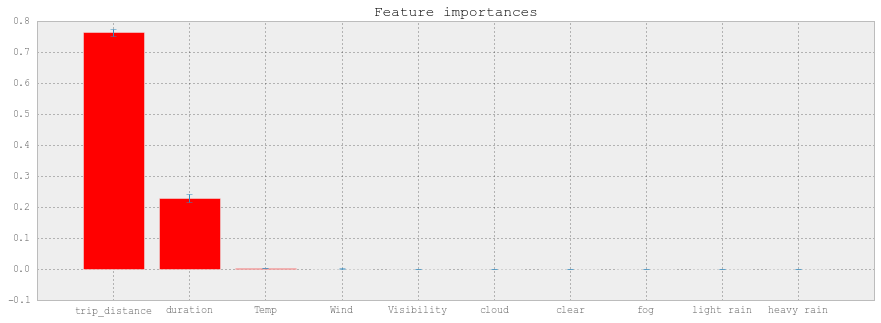

In [17]:
feature_name = list(df.columns)
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)):
    print("%d. feature %s (%f)" % (f + 1, feature_name[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_name[indices[f]].split('=')[-1] for f in range(len(indices))])
plt.xlim([-1, X.shape[1]])
plt.show()